# Mule Account Detection — Exploratory Data Analysis

**Phase 1 · EDA Report · Financial Crime Detection**  
**Dataset:** Banking Transactions · 7.4M transactions · 5-year window (Jul 2020 – Jun 2025)

| Metric | Value |
|:--|:--|
| Total Accounts | 40,038 |
| Mule Accounts | 263 (1.09%) |
| Imbalance Ratio | 90:1 |
| Transactions | 7.4M |
| Patterns Found | 7 of 12 tested |
| Features Engineered | 20+ |


---

## 1. Dataset Structure & Relationships

The dataset spans **six interrelated tables**. This is a 20% representative sample — class ratios and distributions are preserved.

| Table | Rows | Description | Key |
|:--|--:|:--|:--|
| customers.csv | 39,988 | Demographics, KYC flags, banking registrations | customer_id |
| accounts.csv | 40,038 | Account attributes, balance metrics, status | account_id |
| transactions (×6 parts) | 7,424,845 | Every transaction — channel, amount, counterparty | account_id |
| customer_account_linkage.csv | 40,038 | Bridge: maps customers → accounts | customer_id, account_id |
| product_details.csv | 39,988 | Product holdings: loans, credit cards, overdraft | customer_id |
| train_labels.csv | 24,023 | Ground truth: is_mule flag, flag date, alert reason | account_id |
| test_accounts.csv | 16,015 | Accounts to predict on in Phase 2 | account_id |

**Join path:**  
`customers` → *(customer_id)* → `linkage` → *(account_id)* → `accounts` → `transactions`  
`customers` → *(customer_id)* → `product_details`  
`accounts` → *(account_id)* → `train_labels` / `test_accounts`

> **Note:** There is no direct customer_id in accounts.csv — you must route through customer_account_linkage. After joining, the master training table has **24,023 rows × 60 columns**.

**Key channels:** UPC/UPD (UPI ~70%), IPM (IMPS), NTD (NEFT), FTD/FTC (Fund transfers), ATW (ATM withdrawal — cash extraction).


---

## 2. The Class Imbalance Problem

| Class | Count | % of Training Set |
|:--|--:|--:|
| Legitimate | 23,760 | 98.91% |
| Mule | 263 | 1.09% |

**Imbalance ratio: 90:1.** A model always predicting "legit" gets 98.91% accuracy — but is completely useless. **AUC-ROC** is the correct evaluation metric.

> ⚠️ In Phase 2, SMOTE oversampling or class-weight balancing will be applied.

Mule accounts span **13 distinct alert reasons** — no single pattern dominates:

With only 263 mule cases in this sample, differences smaller than ~5 percentage 
points should be interpreted with caution — they may not be statistically robust 
at this sample size.


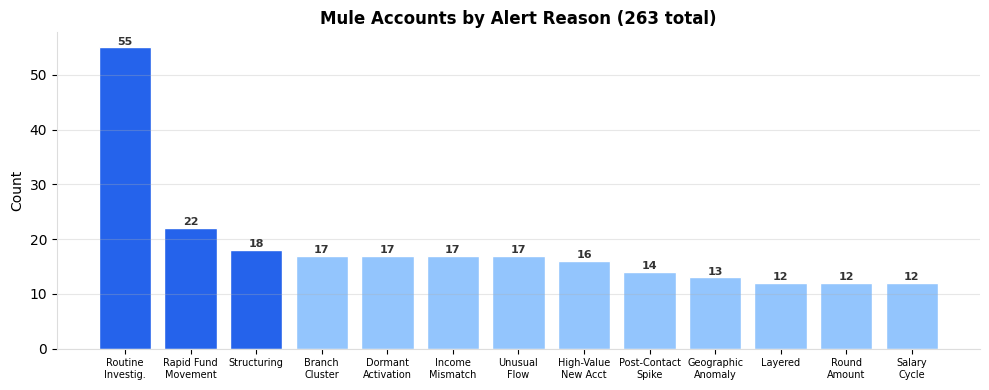

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'figure.facecolor':'white','axes.facecolor':'white',
    'axes.edgecolor':'#ddd','font.family':'DejaVu Sans','font.size':10})

fig, ax = plt.subplots(figsize=(10, 4))
reasons = ['Routine\nInvestig.','Rapid Fund\nMovement','Structuring','Branch\nCluster',
           'Dormant\nActivation','Income\nMismatch','Unusual\nFlow','High-Value\nNew Acct',
           'Post-Contact\nSpike','Geographic\nAnomaly','Layered','Round\nAmount','Salary\nCycle']
counts = [55,22,18,17,17,17,17,16,14,13,12,12,12]
colors = ['#2563eb' if i<3 else '#93c5fd' for i in range(len(counts))]
bars = ax.bar(reasons, counts, color=colors, edgecolor='white')
for b,c in zip(bars,counts):
    ax.text(b.get_x()+b.get_width()/2, c+0.5, str(c), ha='center', fontsize=8, fontweight='600', color='#333')
ax.set_ylabel('Count'); ax.set_title('Mule Accounts by Alert Reason (263 total)', fontweight='bold')
ax.grid(axis='y',alpha=0.3); ax.spines[['top','right']].set_visible(False)
plt.xticks(fontsize=7); plt.tight_layout(); plt.show()

---

## 3. Mule vs Legitimate — Statistical Comparison

All values are **medians** to reduce outlier sensitivity. Signal strength = separation between the two distributions.

| Feature | Mule | Legit | Ratio | Signal |
|:--|--:|--:|:--|:--|
| Frozen account rate | **39.92%** | 2.04% | 19.6× | 🔴 Very Strong |
| Pass-through rate | **7.53%** | 0.00% | ∞ | 🔴 Very Strong |
| Unique counterparties | **30** | 10 | 3.0× | 🔴 Strong |
| Avg txn amount (₹) | **14,845** | 7,343 | 2.0× | 🔴 Strong |
| Total txn count | **67.5** | 38.0 | 1.8× | 🔵 Moderate |
| ATM withdrawal % | **1.69%** | 0.00% | ∞ | 🔵 Moderate |
| IMPS txns % | **6.59%** | 4.17% | 1.6× | 🔵 Moderate |
| NEFT debit % | **4.40%** | 1.93% | 2.3× | 🔵 Moderate |
| Mobile update rate | **20.53%** | 14.75% | 1.4× | 🟡 Weak |
| Standing instruction % | 0.00% | **1.10%** | inverse | 🟡 Weak |
| Avg balance (₹) | 3,561 | **5,260** | – | 🟡 Weak |
| Aadhaar available | 38.0% | **47.1%** | – | 🟡 Weak |
| Round amount % | 11.5% | 16.78% | – | ⚪ None |
| Customer age | 49.9 | 49.5 | – | ⚪ None |
| Relationship tenure | 15.5 yrs | 15.4 yrs | – | ⚪ None |


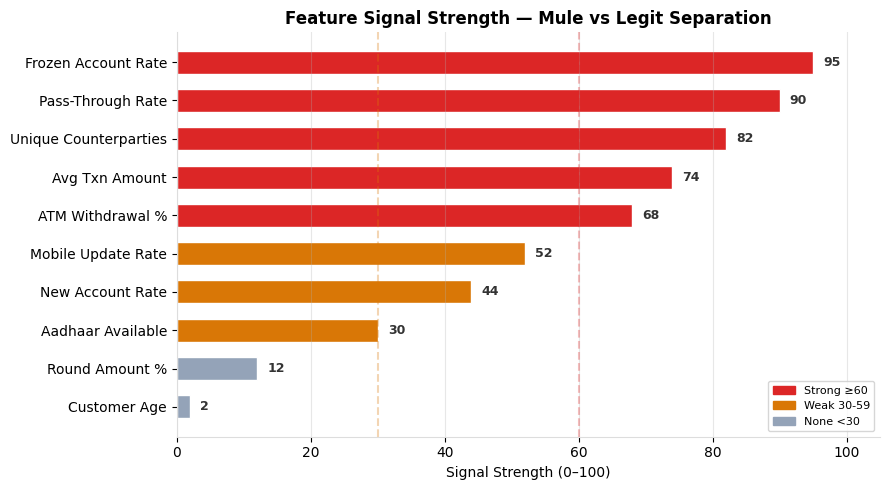

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(9, 5))
labels = ['Frozen Account Rate','Pass-Through Rate','Unique Counterparties',
          'Avg Txn Amount','ATM Withdrawal %','Mobile Update Rate',
          'New Account Rate','Aadhaar Available','Round Amount %','Customer Age']
scores = [95,90,82,74,68,52,44,30,12,2]
colors = ['#dc2626' if s>=60 else ('#d97706' if s>=30 else '#94a3b8') for s in scores]
ax.barh(labels[::-1], scores[::-1], color=colors[::-1], height=0.6, edgecolor='white')
for i,(s,l) in enumerate(zip(scores[::-1],labels[::-1])):
    ax.text(s+1.5, i, str(s), va='center', fontsize=9, fontweight='600', color='#333')
ax.set_xlim(0,105); ax.set_xlabel('Signal Strength (0–100)')
ax.set_title('Feature Signal Strength — Mule vs Legit Separation', fontweight='bold')
ax.axvline(60,color='#dc2626',ls='--',alpha=0.3); ax.axvline(30,color='#d97706',ls='--',alpha=0.3)
ax.grid(axis='x',alpha=0.3); ax.spines[['top','right']].set_visible(False)
ax.legend(handles=[mpatches.Patch(color='#dc2626',label='Strong ≥60'),
    mpatches.Patch(color='#d97706',label='Weak 30-59'),
    mpatches.Patch(color='#94a3b8',label='None <30')], loc='lower right', fontsize=8)
plt.tight_layout(); plt.show()

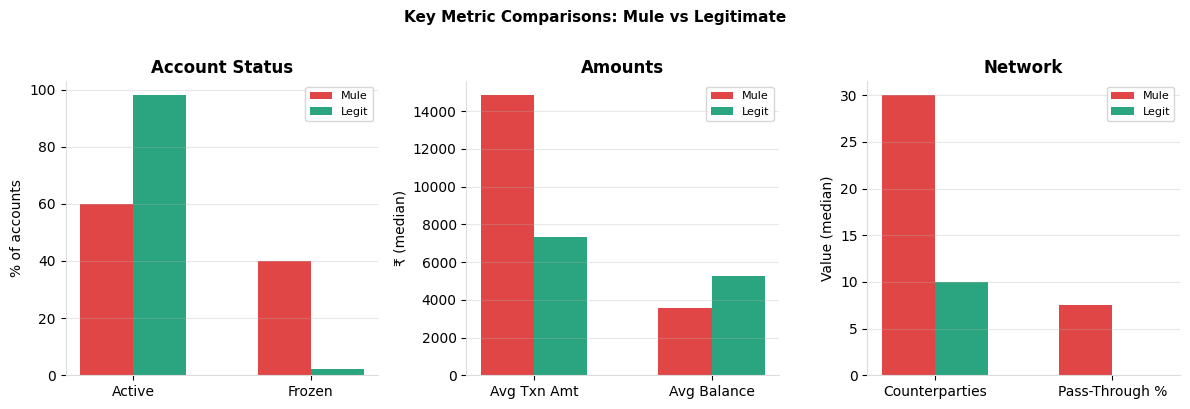

In [13]:
import matplotlib.pyplot as plt
import numpy as np

MULE='#dc2626'; LEGIT='#059669'; w=0.3
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Key Metric Comparisons: Mule vs Legitimate', fontsize=11, fontweight='bold', y=1.01)

ax=axes[0]; x=np.arange(2)
ax.bar(x-w/2,[60.08,39.92],w,label='Mule',color=MULE,alpha=0.85)
ax.bar(x+w/2,[97.96,2.04],w,label='Legit',color=LEGIT,alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Active','Frozen'])
ax.set_ylabel('% of accounts'); ax.set_title('Account Status',fontweight='bold')
ax.legend(fontsize=8); ax.grid(axis='y',alpha=0.3); ax.spines[['top','right']].set_visible(False)

ax=axes[1]; x=np.arange(2)
ax.bar(x-w/2,[14845,3561],w,label='Mule',color=MULE,alpha=0.85)
ax.bar(x+w/2,[7343,5260],w,label='Legit',color=LEGIT,alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Avg Txn Amt','Avg Balance'])
ax.set_ylabel('₹ (median)'); ax.set_title('Amounts',fontweight='bold')
ax.legend(fontsize=8); ax.grid(axis='y',alpha=0.3); ax.spines[['top','right']].set_visible(False)

ax=axes[2]; x=np.arange(2)
ax.bar(x-w/2,[30,7.53],w,label='Mule',color=MULE,alpha=0.85)
ax.bar(x+w/2,[10,0],w,label='Legit',color=LEGIT,alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Counterparties','Pass-Through %'])
ax.set_ylabel('Value (median)'); ax.set_title('Network',fontweight='bold')
ax.legend(fontsize=8); ax.grid(axis='y',alpha=0.3); ax.spines[['top','right']].set_visible(False)
plt.tight_layout(); plt.show()

---

## 4. Pattern Identification

12 known mule patterns were tested against the data. **7 confirmed, 2 not found, 1 counterintuitive, 2 untestable.**

### Confirmed Patterns

| Pattern | Mule | Legit | Strength |
|:--|:--|:--|:--|
| **Rapid Pass-Through** — money in & out same day | 7.53% of days | 0.00% | 🔴 Very Strong |
| **Fan-In/Fan-Out** — wide counterparty network | 30 counterparties | 10 | 🔴 Strong |
| **Income Mismatch** — high txn amt, low balance | ₹14,845 txn / ₹3,561 bal | ₹7,343 / ₹5,260 | 🔴 Strong |
| **Post-Mobile-Change Spike** — account takeover signal | 20.53% updated | 14.75% | 🟡 Weak |
| **New Account High Value** — new accts have 2× mule rate | 2.15% | 1.02% | 🟡 Weak |
| **Branch Collusion** — cluster investigation | 17/263 mules (6.5%) | — | 🔵 Indirect |
| **Structuring** — near-₹50K transactions | Median: 1 txn | 0 | 🟡 Partial |

### Not Found / Counterintuitive

| Pattern | Finding |
|:--|:--|
| **Dormant Activation** | Max gap: 81 days (mule) vs 86 days (legit) — no difference |
| **Round Amounts** | Mules use *fewer* round amounts (11.5% vs 16.78%) — opposite of expected |
| **Geographic Anomaly** | No transaction-level location data — untestable |

> ✅ **Novel finding:** ATM withdrawals (ATW) appear in **1.69% of mule txns vs 0% for legit**. Physical cash extraction = final laundering step. Not listed in the README.


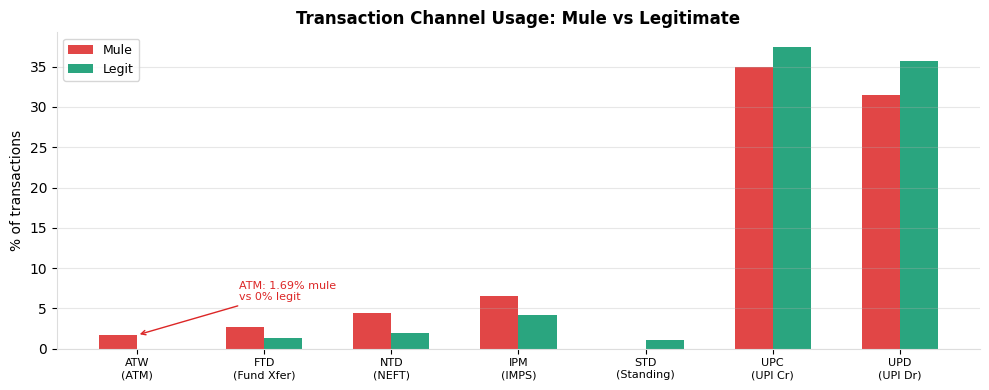

In [14]:
import matplotlib.pyplot as plt
import numpy as np

MULE='#dc2626'; LEGIT='#059669'; w=0.3
fig, ax = plt.subplots(figsize=(10, 4))
channels = ['ATW\n(ATM)','FTD\n(Fund Xfer)','NTD\n(NEFT)','IPM\n(IMPS)',
            'STD\n(Standing)','UPC\n(UPI Cr)','UPD\n(UPI Dr)']
mule_ch  = [1.69,2.65,4.40,6.59,0.00,34.97,31.50]
legit_ch = [0.00,1.29,1.93,4.17,1.10,37.39,35.73]
x = np.arange(len(channels))
ax.bar(x-w/2,mule_ch,w,label='Mule',color=MULE,alpha=0.85)
ax.bar(x+w/2,legit_ch,w,label='Legit',color=LEGIT,alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(channels,fontsize=8)
ax.set_ylabel('% of transactions')
ax.set_title('Transaction Channel Usage: Mule vs Legitimate', fontweight='bold')
ax.legend(fontsize=9); ax.grid(axis='y',alpha=0.3); ax.spines[['top','right']].set_visible(False)
ax.annotate('ATM: 1.69% mule\nvs 0% legit', xy=(0,1.69), xytext=(0.8,6),
            arrowprops=dict(arrowstyle='->', color=MULE), fontsize=8, color=MULE)
plt.tight_layout(); plt.show()

---

## 5. Feature Engineering Plan

Every feature justified by EDA evidence, ordered by predictive strength.

**Group A — Transaction Behaviour (HIGH priority)**

| Feature | Description |
|:--|:--|
| `pass_through_rate` | % of active days with both credit AND debit (7.53% vs 0%) |
| `unique_counterparties` | Distinct counterparty count (30 vs 10) |
| `avg_txn_amount` | Mean transaction amount (₹14,845 vs ₹7,343) |
| `atm_withdrawal_pct` | % via ATW channel (1.69% vs 0%) |
| `imps_neft_pct` | % via IPM + NTD (11% vs 6.1%) |
| `net_flow_ratio` | (credits − debits) / credits — near zero for pass-through |
| `txn_velocity_per_month` | Txn count / active months (1.8× higher for mules) |
| `near_50k_count` | Transactions ₹45K–₹50K — structuring signal |
| `burst_ratio` | Max 7-day txns / avg weekly rate |
| `std_instruction_pct` | % via STD — absence = no stable financial routine |

**Group B — Account-Level (HIGH priority)**

| Feature | Description |
|:--|:--|
| `is_frozen` | account_status == 'frozen' (40% vs 2%) — **leakage caution** |
| `balance_to_txn_ratio` | avg_balance / avg_txn_amount — low = pass-through |
| `account_age_days` | Days since opening — new accounts have 2× mule rate |
| `had_mobile_update` | Mobile update exists — account takeover signal |

**Group C — Customer Identity (MEDIUM priority)**

| Feature | Description |
|:--|:--|
| `kyc_id_score` | Sum of KYC documents on file (PAN + Aadhaar + Passport) |
| `digital_banking_score` | Sum of digital banking flags |

**Group D — Network / Branch (MEDIUM priority)**

| Feature | Description |
|:--|:--|
| `branch_mule_concentration` | % of training mules at same branch |
| `shared_mule_counterparty` | Counterparties shared with known mules |

> ⚠️ Group D features must be computed from training labels only — never test labels.


---

## 6. Data Quality & Leakage Risks

### Columns to exclude (data leakage)

| Column | Reason |
|:--|:--|
| `alert_reason` | Empty for all legit accounts — directly encodes label |
| `mule_flag_date` | Only exists post-detection |
| `flagged_by_branch` | Exists only because account was caught |
| `freeze_date` / `unfreeze_date` | Consequence of fraud detection, not predictor |
| `account_status` (frozen) | **Grey area** — strongest predictor but may be post-detection |

### Missing values

| Column | Missing | Action |
|:--|--:|:--|
| alert_reason, flag_date, flagged_by | ~23,760 | 🔴 Exclude — structurally empty for legit |
| freeze/unfreeze_date | ~23,750 | 🔴 Exclude — leakage |
| last_mobile_update_date | 20,465 | 🔵 Keep — presence is itself a signal |
| cc_sum / loan_sum | 18,904–20,233 | 🟡 Treat as 0 (no credit products) |
| aadhaar / pan_available | 5,790 / 3,435 | 🔵 Keep — missing KYC = risk signal |
| avg_balance | 725 | ⚪ Impute — negligible missing rate |

### Noisy labels

> ⚠️ Labels may contain noise (per README). With only 263 mules, ~13 mislabelled accounts (5%) could meaningfully shift model behaviour. Use label smoothing and robust ensembles in Phase 2.

> ⚠️ Since this is a 20% sample, patterns requiring large numbers to emerge (e.g.,structuring, dormancy bursts) may become clearer in the full dataset. Feature importance rankings may also shift when trained on 5× more data.


---

## 7. Key Takeaways & Phase 2 Direction

| Finding | Detail |
|:--|:--|
| **Top behavioural signal** | Pass-through — money in/out same day (7.53% vs 0%) |
| **Strongest predictor** | Frozen status (40% vs 2%) — use with leakage caution |
| **Novel finding** | ATM withdrawals (1.69% vs 0%) — cash extraction endpoint |
| **Null findings** | Age, tenure, dormancy, round amounts — no signal |

**The mule account profile:** High transaction velocity, large amounts, wide counterparty networks, same-day fund cycling — a **financial pipeline**, not a personal account.

**Phase 2 approach:** Gradient boosted tree (XGBoost/LightGBM) on 20+ features with class-weight balancing. Metric: AUC-ROC.

> ✅ **Bottom line:** Features capturing pipeline behaviour — pass-through rate, counterparty breadth, channel mix, and balance-to-transaction ratio — will drive a high-AUC model.

---

*Phase 1 EDA Report · 7.4M transactions · 40,038 accounts · Jul 2020–Jun 2025 · 20% sample*
